#### calculate motif activity

In [1]:
import os, sys, re, warnings

# plotting functions
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle

# data handling
import scipy
from scipy import stats
from scipy.cluster import hierarchy
import numpy as np
import pandas as pd

from scikit_posthocs import posthoc_tukey
from statannotations.Annotator import Annotator

In [3]:
# set up directories
scriptdir=os.path.join(os.getcwd(), "utils")
sys.path.insert(0, scriptdir)

outbase_dir = os.path.split(os.getcwd())[0]
mpra_designdir = os.path.join(os.path.split(outbase_dir)[0], "hdmuts_library_design")

In [5]:
from utils import specseq_plot_utils, mpra_qc_normalization, mpra_plot_utils, chipseq_plot_utils, specseq_ewm_utils, specseq_predict_occp, sequence_annotator
specseq_plot_utils.set_manuscript_params()

In [33]:
## spec-seq scheme colorRampPalette(c("#CF8B03", "#FFFFFF" , "#50A1CF"))
# assign color to class
color_map = {
    "WT": "#E69B04",
    "E80A": "#009980",
    "K88N": "#59B3E6",
    "R90W": "#1A1A1A"
}

pretty_names = pd.Series({"wt":"WT","ehet":"E80A/+","ehom":"E80A/A","khet":"K88N/+","khom":"K88N/N","rhom":"R90W/W",
                         "at":"E80A/+","aa":"E80A/A","nt":"K88N/+","nn":"K88N/N","ww":"R90W/W",})

### I. read pre-processed data

In [13]:
# e80a versus wt bulk ATAC differential analysis
e80a_atac_df = pd.read_csv(os.path.join(outbase_dir, "peaksets", "atac_e80a_readsInPeakNormed.compiled_matrix.intersect_chip.tsv"), sep="\t", header=0)

# CRE motif position information
fimo_th = 2.5e-3
allMonomerSites = pd.read_csv(os.path.join(mpra_designdir, "peaksets", f"allMonomerMutatedSites.fimo{fimo_th}.tsv"), sep="\t", header=0)
allDimerSites = pd.read_csv(os.path.join(mpra_designdir, "peaksets", f"allDimerMutatedSites.fimo{fimo_th}.tsv"), sep="\t", header=0)

# CRE annotation table
annot_df = pd.read_csv(os.path.join(outbase_dir, "compiled_counts", "hdmuts_full_annot.tsv"), sep="\t", header=0)
# simple annotation
simple_annot = annot_df.drop_duplicates(subset="annots", keep="first").reset_index(drop=True).set_index("annots")

#### CRE activity matrices

In [50]:
# read directly from file
CRE_enhancer_activity_ser = {}
for genotype in ["wt","ehet","ehom","khet","khom","rhom"]:

    CRE_enhancer_activity_ser[genotype] = pd.read_csv(os.path.join(outbase_dir, "compiled_counts", "activity", f"deseq2_{genotype}_rna_scrambled_normalized_statistics.tsv"), sep="\t", header=0).set_index("annots")
    
CRE_enhancer_activity_ser = pd.Series(CRE_enhancer_activity_ser)

### II. for each genomic CRE, find its corresponding mutM, mutD, and mutDM variants

In [16]:
# drop basal
uniqueCRE_annot = simple_annot.loc[~simple_annot.index.str.contains("basal"),:].sort_values(by=["peak.id","motif"])
# drop any scrambled or control CREs
uniqueCRE_annot = uniqueCRE_annot.loc[~(uniqueCRE_annot.index.str.contains("shuff")|uniqueCRE_annot.index.str.contains("control")|uniqueCRE_annot.index.str.contains("RetinalGene")),:]
# per peak/CRE retrieve the corresponding motif type in the library, and convert annotation from index to column
uniqueCRE_motifType = uniqueCRE_annot.groupby(["peak.id","annotation"])["motif"].unique().to_frame().reset_index(level="annotation", drop=False)

# explode the motif lists for each CRE into columns of mask
for motiftype in ["WT","mutM","mutD","mutDM"]:
    uniqueCRE_motifType[motiftype] = uniqueCRE_motifType.motif.apply(lambda alltypes: motiftype in alltypes)
    
# CREs with all four types of motifs
uniqueCRE_DM = uniqueCRE_motifType.loc[uniqueCRE_motifType.motif.apply(lambda alltypes: len(alltypes)==4),:].copy()
# CREs with only WT and mutM motifs
uniqueCRE_M = uniqueCRE_motifType.loc[uniqueCRE_motifType.motif.apply(lambda alltypes: (len(alltypes)==2)&("mutM" in alltypes)),:].copy()
# CREs with only WT and mutD motifs
uniqueCRE_D = uniqueCRE_motifType.loc[uniqueCRE_motifType.motif.apply(lambda alltypes: (len(alltypes)==2)&("mutD" in alltypes)),:].copy()
# CREs with only WT motifs
uniqueCRE_WT = uniqueCRE_motifType.loc[uniqueCRE_motifType.motif.apply(lambda alltypes: len(alltypes)==1),:].copy()

#### for each type of CRE, compile all the different genotypes in one matrix

In [51]:
# collect genotype data for each category of CREs
mutHD_activity_ser = {}
for genotype in ["wt","ehet","ehom","khet","khom","rhom"]:
    for category, mut_peaks in zip(["mutM","mutD","mutDM"], [uniqueCRE_M, uniqueCRE_D, uniqueCRE_DM]):
        # use scrambled noramlized
        activity_subset = pd.merge(CRE_enhancer_activity_ser[genotype], simple_annot[["peak.id","motif"]], left_index=True, right_index=True, how="inner")
        # pick those CREs with certain motif type
        tmp = activity_subset.loc[(activity_subset["peak.id"].isin(mut_peaks.index))&(activity_subset["motif"]!="scrambled"),:]
        #display(tmp.groupby("motif")["peak.id"].count())
        
        # convert the long from dataframe to wide but stacking the CRE of the same peak on the same row, need to drop annots
        tmp_pivoted = tmp.pivot_table(index="peak.id", columns="motif", values="expression", aggfunc=np.sum, fill_value=0)
        tmp_pivoted = tmp_pivoted.rename(columns={k:f"{k}.expression" for k in tmp_pivoted.columns})

        mutHD_activity_ser[f"{genotype}.{category}"] = tmp_pivoted

mutHD_activity_ser = pd.Series(mutHD_activity_ser)

#### record CREs that correspond to M, D, M+D classes, the WT-mut form expression correspondence

In [18]:
uniqueM_df = pd.DataFrame(index=uniqueCRE_annot.sort_values(by="peak.id")["peak.id"].unique())
uniqueD_df = pd.DataFrame(index=uniqueCRE_annot.sort_values(by="peak.id")["peak.id"].unique())
uniqueDM_df = pd.DataFrame(index=uniqueCRE_annot.sort_values(by="peak.id")["peak.id"].unique())

In [52]:
uniqueMotifKilled_ser = {}
for category, activity_df in zip(["mutM","mutD","mutDM"],[uniqueM_df,uniqueD_df,uniqueDM_df]):
    
    for genotype in CRE_enhancer_activity_ser.index:
        tmp = mutHD_activity_ser[f"{genotype}.{category}"].rename(columns={k:f"{genotype}.{k.replace('ression','')}" for k in mutHD_activity_ser[f"{genotype}.{category}"].columns})
        # reorder DM category columns
        if category == "mutDM":
            tmp = tmp.iloc[:,[0,3,1,2]]
        
        # attach to full dataframe
        activity_df = pd.merge(activity_df, tmp, left_index=True, right_index=True, how="left")
        activity_df.index.name = "peak.id"
        del(tmp)
    
    # drop rows where all are NaN
    activity_df = activity_df.dropna(how="all")
    uniqueMotifKilled_ser[category] = activity_df

uniqueMotifKilled_ser = pd.Series(uniqueMotifKilled_ser)

In [53]:
uniqueMotifKilled_ser["mutM"].loc[:,lambda df: df.columns[~(df.columns.str.contains("ehet")|df.columns.str.contains("khet")|df.columns.str.contains("rhom"))]].to_csv(os.path.join("/mnt/v/yqzheng/qiaoer/VSCode_yiqiao","ToShare", "032523_mpra_M_CRE_activity.tsv"), sep="\t", header=True, index=True)
uniqueMotifKilled_ser["mutD"].loc[:,lambda df: df.columns[~(df.columns.str.contains("ehet")|df.columns.str.contains("khet")|df.columns.str.contains("rhom"))]].to_csv(os.path.join("/mnt/v/yqzheng/qiaoer/VSCode_yiqiao","ToShare", "032523_mpra_D_CRE_activity.tsv"), sep="\t", header=True, index=True)
uniqueMotifKilled_ser["mutDM"].loc[:,lambda df: df.columns[~(df.columns.str.contains("ehet")|df.columns.str.contains("khet")|df.columns.str.contains("rhom"))]].to_csv(os.path.join("/mnt/v/yqzheng/qiaoer/VSCode_yiqiao","ToShare", "032523_mpra_DM_CRE_activity.tsv"), sep="\t", header=True, index=True)

#### compile all the WT-mut form in one big dataframe

In [57]:
allMotifKilled_ser= {}
for genotype in CRE_enhancer_activity_ser.index:
    tmp_df = pd.DataFrame(columns=["WT.expression","mut.expression"])
    tmp_df.index.name = "peak.id"
    
    for category in ["mutM","mutD","mutDM"]:
        tmp_df = pd.concat([tmp_df, mutHD_activity_ser[f"{genotype}.{category}"][["WT.expression",f"{category}.expression"]].rename(columns={f"{category}.expression":"mut.expression"})])

    allMotifKilled_ser[genotype] = tmp_df

allMotifKilled_ser = pd.Series(allMotifKilled_ser)

In [58]:
allMotifKilled_df = pd.DataFrame(index=uniqueCRE_annot.sort_values(by="peak.id")["peak.id"].unique())

In [59]:
for genotype in allMotifKilled_ser.index:
    tmp = allMotifKilled_ser[genotype].rename(columns={"WT.expression":f"{genotype}.WT.exp",
                                                       "mut.expression":f"{genotype}.mut.exp"})
    
    # delta activity is calculated as WT/mut expression, so that when take log(Delta) if mut<WT it becomes negative
    #tmp[f"{genotype}.delta.exp"] = tmp[f"{genotype}.WT.exp"]/tmp[f"{genotype}.mut.exp"]
    # attach to full dataframe
    allMotifKilled_df = pd.merge(allMotifKilled_df, tmp, left_index=True, right_index=True, how="left")

    del(tmp)

# drop rows that are all NaN
allMotifKilled_df = allMotifKilled_df.dropna(how="all")
allMotifKilled_df.index.name = "peak.id"

In [60]:
allMotifKilled_df[allMotifKilled_df.columns[~(allMotifKilled_df.columns.str.contains("ehet")|allMotifKilled_df.columns.str.contains("khet")|allMotifKilled_df.columns.str.contains("rhom"))]].to_csv(os.path.join("/mnt/v/yqzheng/qiaoer/VSCode_yiqiao","ToShare", "032523_mpra_allMotifsKilled_CRE_activity.tsv"), sep="\t", header=True, index=True)

### III. calculate motif activity - CRE activity difference between genomic (WT) and variant sequences

In [61]:
uniqueMotifActivity_ser = pd.Series(dtype=object)
for idx in uniqueMotifKilled_ser.index:
    motif_type = idx[3:]
    tmp_df = uniqueMotifKilled_ser[idx].copy()
    for genotype in ["wt","ehet", "ehom", "khet", "khom", "rhom"]:
        if motif_type == "DM":
            tmp_df[f"{genotype}.M.exp"] = tmp_df[f"{genotype}.mutD.exp"]/tmp_df[f"{genotype}.mutDM.exp"]
            tmp_df[f"{genotype}.D.exp"] = tmp_df[f"{genotype}.mutM.exp"]/tmp_df[f"{genotype}.mutDM.exp"]
            tmp_df[f"{genotype}.DM.exp"] = tmp_df[f"{genotype}.WT.exp"]/tmp_df[f"{genotype}.mutDM.exp"]
            # the opposite way, whether it perturbs the activity
            #tmp_df[f"{genotype}.M.exp"] = tmp_df[f"{genotype}.mutM.exp"]/tmp_df[f"{genotype}.WT.exp"]
            #tmp_df[f"{genotype}.D.exp"] = tmp_df[f"{genotype}.mutD.exp"]/tmp_df[f"{genotype}.WT.exp"]
            #tmp_df[f"{genotype}.DM.exp"] = tmp_df[f"{genotype}.mutDM.exp"]/tmp_df[f"{genotype}.WT.exp"]
            uniqueMotifActivity_ser[idx] = tmp_df.iloc[:,[-(x+1) for x in range(18)]].copy()
        else:
            tmp_df[f"{genotype}.{motif_type}.exp"] = tmp_df[f"{genotype}.WT.exp"]/tmp_df[f"{genotype}.{idx}.exp"]
            #tmp_df[f"{genotype}.{motif_type}.exp"] = tmp_df[f"{genotype}.{idx}.exp"]/tmp_df[f"{genotype}.WT.exp"]
            uniqueMotifActivity_ser[idx] = tmp_df.iloc[:,[-(x+1) for x in range(6)]].copy()

#### summarize dimeric or monomeric motif activities from different genotypes into a single dataframe

In [62]:
plot_gntyps = ["wt","ehet","ehom"]
# dimeric motif from both DM and D CREs
all_dimer_CRE_activity = pd.concat([uniqueMotifActivity_ser["mutD"][[f"{geno}.D.exp" for geno in plot_gntyps]],
                                    uniqueMotifActivity_ser["mutDM"][[f"{geno}.D.exp" for geno in plot_gntyps]]], axis=0)
# drop any row with na, inf, and impose some constraints on fc
mask = abs(all_dimer_CRE_activity.apply(np.log2))>=0
#mask = all_dimer_CRE_activity.apply(np.log2)>0.55
all_dimer_CRE_activity.replace([np.inf, -np.inf], np.nan, inplace=True)
all_dimer_CRE_activity = all_dimer_CRE_activity[mask.sum(axis=1) != 0].dropna().reset_index(drop=False).rename(columns={"index":"peak.id"})

all_dimer_CRE_activity[f"{plot_gntyps[1]}.dd.exp"] = all_dimer_CRE_activity[f"{plot_gntyps[1]}.D.exp"]/all_dimer_CRE_activity["wt.D.exp"] 
all_dimer_CRE_activity[f"{plot_gntyps[2]}.dd.exp"] = all_dimer_CRE_activity[f"{plot_gntyps[2]}.D.exp"]/all_dimer_CRE_activity["wt.D.exp"] 

# drop rows with 0.0 and NaN
all_dimer_CRE_activity = all_dimer_CRE_activity[all_dimer_CRE_activity.isna().sum(axis=1)==0]

# attach the CRE class columns
all_dimer_CRE_activity["class"] = "D"
all_dimer_CRE_activity[["class"]] = all_dimer_CRE_activity[["class"]].mask(all_dimer_CRE_activity["peak.id"].isin(uniqueMotifActivity_ser["mutDM"].index), "DM", inplace=False)

In [63]:
# monomeric motif from both DM and M CREs
all_mono_CRE_activity = pd.concat([uniqueMotifActivity_ser["mutM"][[f"{geno}.M.exp" for geno in plot_gntyps]],
                                    uniqueMotifActivity_ser["mutDM"][[f"{geno}.M.exp" for geno in plot_gntyps]]], axis=0)
# drop any row with na, inf, and impose some constraints on fc
mask = abs(all_mono_CRE_activity.apply(np.log2))>=0
#mask = all_mono_CRE_activity.apply(np.log2)>0.55
all_mono_CRE_activity.replace([np.inf, -np.inf], np.nan, inplace=True)
all_mono_CRE_activity = all_mono_CRE_activity[mask.sum(axis=1) != 0].dropna().reset_index(drop=False).rename(columns={"index":"peak.id"})

all_mono_CRE_activity[f"{plot_gntyps[1]}.dd.exp"] = all_mono_CRE_activity[f"{plot_gntyps[1]}.M.exp"]/all_mono_CRE_activity["wt.M.exp"] 
all_mono_CRE_activity[f"{plot_gntyps[2]}.dd.exp"] = all_mono_CRE_activity[f"{plot_gntyps[2]}.M.exp"]/all_mono_CRE_activity["wt.M.exp"] 

# drop rows with 0.0 and NaN
all_mono_CRE_activity = all_mono_CRE_activity[all_mono_CRE_activity.isna().sum(axis=1)==0]

# attach the CRE class columns
all_mono_CRE_activity["class"] = "M"
all_mono_CRE_activity[["class"]] = all_mono_CRE_activity[["class"]].mask(all_mono_CRE_activity["peak.id"].isin(uniqueMotifActivity_ser["mutDM"].index), "DM", inplace=False)

#### criteria to call a dimeric or monomeric motif

In [64]:
k50_mono_df = allMonomerSites.loc[lambda df: df["motif_id"]=="CRX_Corbo",:].copy()
k50_mono_df["core"] = k50_mono_df["matched_sequence"].apply(lambda x: x[1:7])

In [65]:
k50_dimer_df = pd.read_csv(os.path.join(mpra_designdir, f"fimo_{fimo_th}", "allCRE_fimo", "fimo.tsv"), sep="\t", header=0)
k50_dimer_df =k50_dimer_df.loc[lambda df: df["motif_id"]=="e80a_loss.MEME.3",:].copy()
k50_dimer_df["spacer"] = k50_dimer_df["matched_sequence"].apply(lambda x: x[4:7])
k50_dimer_df["flk"] = k50_dimer_df["matched_sequence"].apply(lambda x: x[3]+x[7])

#### dimeric motif containing CREs

In [66]:
# first define a set that is important for activity based on wt data
wt_responsive_dimer_CRE_activity = all_dimer_CRE_activity[all_dimer_CRE_activity["wt.D.exp"].apply(np.log2)>np.log2(1.5)].copy()

In [67]:
motif_type = "D"

# transform the dataframe to long-form
melted_tmp = pd.melt(wt_responsive_dimer_CRE_activity, id_vars="peak.id", value_vars=[f"{geno}.{motif_type}.exp" for geno in plot_gntyps], var_name="genotype", value_name="fc")
# plot log2 absolute activity
melted_tmp["log.fc"] = melted_tmp["fc"].apply(np.log2)
melted_tmp["abs.log.fc"] = melted_tmp["log.fc"].apply(np.abs)

# filter by further criteria
# match motif type - lys or gln
melted_tmp = melted_tmp.loc[lambda df: df["peak.id"].isin(k50_dimer_df["sequence_name"])]
melted_tmp = melted_tmp.loc[lambda df: df["peak.id"].isin(allDimerSites["sequence_name"])]

# changes in chip
melted_tmp = melted_tmp.loc[lambda df: df["peak.id"].isin(e80a_atac_df.loc[lambda df: df["aa_atac_cluster"]=="aa.atac.notDA","chip.peak.id"])]

wt.D.exp vs. ehet.D.exp: Mann-Whitney-Wilcoxon test two-sided, P_val:5.506e-02 U_stat=2.525e+03
wt.D.exp vs. ehom.D.exp: Mann-Whitney-Wilcoxon test two-sided, P_val:2.104e-01 U_stat=2.382e+03


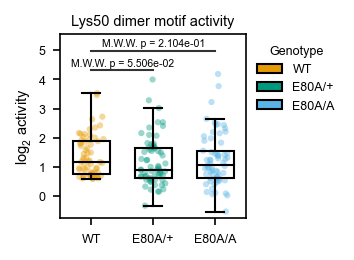

In [68]:
fig, ax = plt.subplots(figsize=(1.6,1.6), dpi=150)

# color by genotype
cmap = {k:v for k,v in zip([f"{geno}.{motif_type}.exp" for geno in plot_gntyps],list(color_map.values())[:3])}

box_props = {
    'boxprops':{'edgecolor':'black', 'facecolor':'none', 'alpha': 1, 'zorder': 10}, #'facecolor':'none', 
    'medianprops':{'color':'black','alpha': 1, },
    'whiskerprops':{'color':'black','alpha': 1, },
    'capprops':{'color':'black','alpha': 1, },
}

ax = sns.stripplot(data=melted_tmp, x="genotype", y="log.fc", hue="genotype", 
                   order=[f"{geno}.{motif_type}.exp" for geno in plot_gntyps],
                   palette=cmap, s=3, alpha=0.4,
                   orient="v", ax=ax, zorder=8, jitter=0.2,
    )

ax = sns.boxplot(data=melted_tmp, x="genotype", y="log.fc",
                 order=[f"{geno}.{motif_type}.exp" for geno in plot_gntyps],
                 palette=cmap, dodge=True,
                 width=0.6, linewidth=1.0, showfliers=False, 
                 orient="v", ax=ax, zorder=10,
                **box_props) # additional controls over the boxes

# annotations
# paired wise MWU
pairs = [[f"wt.{motif_type}.exp", f"ehet.{motif_type}.exp"],
         [f"wt.{motif_type}.exp", f"ehom.{motif_type}.exp"],
         #[f"ehet.{motif_type}.exp", f"ehom.{motif_type}.exp"],
         ]
annotator = Annotator(data=melted_tmp, x="genotype", y="log.fc",
                      palette=cmap, ax=ax, pairs=pairs)
annotator.configure(test="Mann-Whitney", text_format='full', 
                      line_width=mpl.rcParams["lines.linewidth"], 
                      line_height=.0, text_offset=1, fontsize=5,).apply_and_annotate()

ax.set(title = f"Lys50 dimer motif activity", xlabel="", ylabel=f"$log_{2}$ activity")
ax.set_xticklabels(["WT",f"{pretty_names[plot_gntyps[1]]}",f"{pretty_names[plot_gntyps[2]]}"])
#ax.set_ylim(-3.6,9)

# customize the legend
# add color patches for chip and atac heatmaps (0, "#CF8B03"), (0.5, "#FFFFFF"), (1, "#08306B")
legend_elements = [Rectangle((0,0), .1, .2,
                             facecolor=list(cmap.values())[0], edgecolor="k",
                                label="WT"),
                        Rectangle((0,0), .1, .2, 
                              facecolor=list(cmap.values())[1], edgecolor="k",
                                label=f"{pretty_names[plot_gntyps[1]]}"),
                        Rectangle((0,0), .1, .2, 
                             facecolor=list(cmap.values())[2], edgecolor="k",
                                label=f"{pretty_names[plot_gntyps[2]]}"),
                    ]

leg = ax.legend(handles=legend_elements, 
                  title="Genotype",
                  loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
    
leg._legend_box.align = "center"

In [69]:
fig.savefig(os.path.join(outbase_dir, "figures", "motif_activity_box", "e80a.lost_CRE_K50dimer_boxplot.png"), dpi=600, bbox_inches="tight")

#### iv. monomeric motif activities

In [70]:
# first define a set that is important for activity based on wt data
mask = all_mono_CRE_activity[[f"{geno}.M.exp" for geno in plot_gntyps]].apply(np.log2)>np.log2(1.5)
wt_responsive_mono_CRE_activity = all_mono_CRE_activity[mask.sum(axis=1) != 0].copy()

In [71]:
motif_type = "M"

# transform the dataframe to long-form
melted_tmp = pd.melt(wt_responsive_mono_CRE_activity, id_vars="peak.id", value_vars=[f"{geno}.{motif_type}.exp" for geno in plot_gntyps], var_name="genotype", value_name="fc")
# plot log2 absolute activity
melted_tmp["log.fc"] = melted_tmp["fc"].apply(np.log2)
melted_tmp["abs.log.fc"] = melted_tmp["log.fc"].apply(np.abs)

# filter by further criteria
# match motif type - lys or gln
melted_tmp = melted_tmp.loc[lambda df: df["peak.id"].isin(k50_mono_df["sequence_name"])]
melted_tmp = melted_tmp.loc[lambda df: df["peak.id"].isin(allMonomerSites["sequence_name"])]

# changes in atac
melted_tmp = melted_tmp.loc[lambda df: df["peak.id"].isin(e80a_atac_df.loc[lambda df: df["aa_atac_cluster"]!="aa.atac.lost","chip.peak.id"])]


wt.M.exp vs. ehet.M.exp: Mann-Whitney-Wilcoxon test two-sided, P_val:2.306e-01 U_stat=9.658e+04
wt.M.exp vs. ehom.M.exp: Mann-Whitney-Wilcoxon test two-sided, P_val:1.794e-06 U_stat=8.263e+04


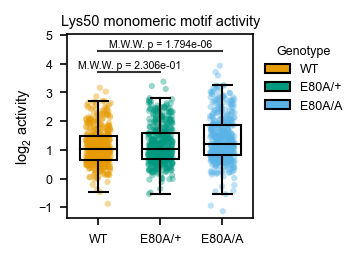

In [72]:
fig, ax = plt.subplots(figsize=(1.6,1.6), dpi=150)

# color by genotype
cmap = {k:v for k,v in zip([f"{geno}.{motif_type}.exp" for geno in plot_gntyps],list(color_map.values())[:3])}

box_props = {
    'boxprops':{'edgecolor':'black', 'facecolor':'none', 'alpha': 1, 'zorder': 10}, #'facecolor':'none', 
    'medianprops':{'color':'black','alpha': 1, },
    'whiskerprops':{'color':'black','alpha': 1, },
    'capprops':{'color':'black','alpha': 1, },
}

ax = sns.stripplot(data=melted_tmp, x="genotype", y="log.fc", hue="genotype", 
                   order=[f"{geno}.{motif_type}.exp" for geno in plot_gntyps],
                   palette=cmap, s=3, alpha=0.4,
                   orient="v", ax=ax, zorder=8, jitter=0.2,
    )

ax = sns.boxplot(data=melted_tmp, x="genotype", y="log.fc",
                 order=[f"{geno}.{motif_type}.exp" for geno in plot_gntyps],
                 palette=cmap, dodge=True,
                 width=0.6, linewidth=1.0, showfliers=False, 
                 orient="v", ax=ax, zorder=10,
                **box_props) # additional controls over the boxes

# annotations
# paired wise MWU
pairs = [[f"wt.{motif_type}.exp", f"ehet.{motif_type}.exp"],
         [f"wt.{motif_type}.exp", f"ehom.{motif_type}.exp"],
         #[f"ehet.{motif_type}.exp", f"ehom.{motif_type}.exp"],
         ]
annotator = Annotator(data=melted_tmp, x="genotype", y="log.fc",
                      palette=cmap, ax=ax, pairs=pairs)
annotator.configure(test="Mann-Whitney", text_format='full', 
                      line_width=mpl.rcParams["lines.linewidth"], 
                      line_height=.0, text_offset=1, fontsize=5,).apply_and_annotate()

ax.set(title = f"Lys50 monomeric motif activity", xlabel="", ylabel=f"$log_{2}$ activity")
ax.set_xticklabels(["WT",f"{pretty_names[plot_gntyps[1]]}",f"{pretty_names[plot_gntyps[2]]}"])

# customize the legend
# add color patches for chip and atac heatmaps (0, "#CF8B03"), (0.5, "#FFFFFF"), (1, "#08306B")
legend_elements = [Rectangle((0,0), .1, .2,
                             facecolor=list(cmap.values())[0], edgecolor="k",
                                label="WT"),
                        Rectangle((0,0), .1, .2, 
                              facecolor=list(cmap.values())[1], edgecolor="k",
                                label=f"{pretty_names[plot_gntyps[1]]}"),
                        Rectangle((0,0), .1, .2, 
                             facecolor=list(cmap.values())[2], edgecolor="k",
                                label=f"{pretty_names[plot_gntyps[2]]}"),
                    ]

leg = ax.legend(handles=legend_elements, 
                  title="Genotype",
                  loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
    
leg._legend_box.align = "center"

In [74]:
fig.savefig(os.path.join(outbase_dir, "figures", "motif_activity_box", "e80a.notLost_CRE_K50mono_boxplot.png"), dpi=600, bbox_inches="tight")